Import the required libraries and the combined dataset mike b created

Drop all rows where any of the data elements are NA

In [1]:
import geopandas as gpd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

Pre-processing of the datasets
- Remove areas with max veg heights > 0.5 m

In [3]:
df = gpd.read_file('./data/shapefiles/geodata.shp')
df = df.dropna()

veg_max = 0.5 # Max veg height we're willing to deal with
df = df[df['vegheight_']<= veg_max]

In [4]:
snow_max = np.round(df.snow_depth.max()+0.5)
snow_min = 0.1
snow_step = 0.01 #Bin width of 1 cm
bsnow = np.arange(snow_min,snow_max,snow_step) #These are the histogram bins

Here we calculate a probability density function (PDF), invert its cumulative density (CDF).
The bins are bound by the observations so we don't extrapolate.

In [6]:
hist, bin_edges = np.histogram(df.snow_depth, bins=bsnow, density=True)
cum_values = np.zeros(bin_edges.shape)
cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
inv_cdf = interpolate.interp1d(cum_values, bin_edges)

Example of how to pull random samples from the distrobution
1. Pick number of samples
2. Generate random numbers between 0-1
3. Use the inverted cdf to pull samples from the known distro
4. Find nearest match in the obs. Need to do this because we interpolate the cdf.

If you pull enough samples, you'll recreate the observed distrobution.

In [7]:
n_samples = 50
r = np.random.rand(n_samples)
depth_sample = inv_cdf(r)
sample_records = [df.iloc[(df['snow_depth']-x).abs().argsort()[:1]] for x in depth_sample]

print(depth_sample[0])
print(sample_records[0].snow_depth)

0.4734902905078374
9542    0.473524
Name: snow_depth, dtype: float64


In [8]:
print('2013 Lidar Snow Stats for SikSik')
print ("Mean: {} ".format(np.round(df.snow_depth.mean(),2)))
print ("StDev: {} ".format(np.round(df.snow_depth.std(),2)))

print('\n2018 Site Stats')
print ("Mean: {} ".format(np.round(depth_sample.mean(),2)))
print ("StDev: {} ".format(np.round(depth_sample.std(),2)))

2013 Lidar Snow Stats for SikSik
Mean: 0.54 
StDev: 0.12 

2018 Site Stats
Mean: 0.56 
StDev: 0.1 


### Basic plot
Formatting of labels and colorbars can get messy, but this is a good way to get a plot or series of axes plotted
1. Setup the figure and axes (default 1 axis per figure)
2. Plot using the pandas/geopandas `.plot()` but being careful to say which axis it should go on

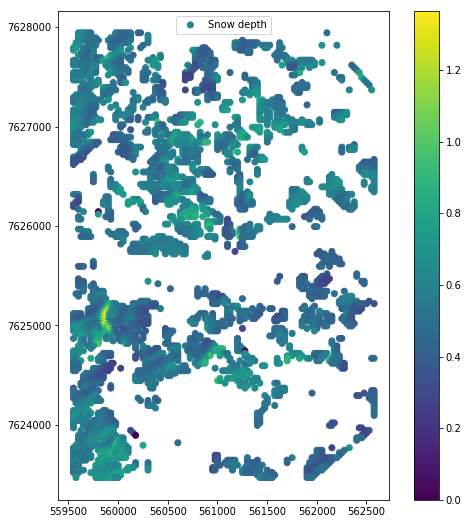

In [19]:
fig, ax = plt.subplots(figsize=(9,9))
df.plot(ax=ax, column='snow_depth', label='Snow depth', legend=True)
ax.legend(); # this just adds the label box within the axis

In [20]:
df.columns

Index(['snow_depth', 'dem_value', 'slope_valu', 'vegheight_', 'geometry'], dtype='object')

## Multi-axis plot

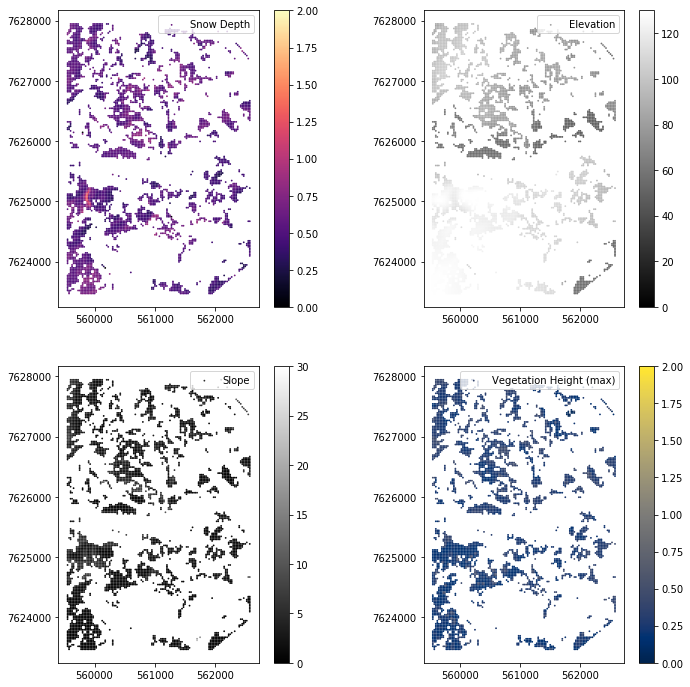

In [26]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
snow, dem, slope, veg = axes.ravel()
df.plot(ax=snow, column='snow_depth', markersize=0.6, vmin=0, vmax=2, cmap='magma', label='Snow Depth', legend=True)
df.plot(ax=dem, column='dem_value', markersize=0.6, vmin=0, vmax=130, cmap='gray', label='Elevation', legend=True)
df.plot(ax=slope, column='slope_valu', markersize=0.6, vmin=0, vmax=30, cmap='gray', label='Slope', legend=True)
df.plot(ax=veg, column='vegheight_', markersize=0.6, vmin=0, vmax=2, cmap='cividis', label='Vegetation Height (max)', legend=True)
snow.legend()
dem.legend()
slope.legend()
veg.legend();